#Comenzamos el proyecto ahora en un .ipynb, para que quede todo un poco más clarito. 


La estructura es:
-Descargamos unos datos de 3 fuentes distintas. Les damos formato, con dataclass. Se grafican para su analisis, se hace la matriz de varianzas y covariazas, se recomienda una cartera con pesos eficientes para esos valores. 

-En otra celda, intentaré descargar información relevante de la empresa y generar un archivo 

In [65]:
# Esta celda carga todas las "herramientas" que vamos a necesitar.
import os
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta, date
from dotenv import load_dotenv  # Para cargar nuestras claves API secretas
import json
import yfinance as yf
from twelvedata import TDClient
from dataclasses import dataclass, asdict # 'dataclass' es nuestro "molde", 'asdict' para convertirlo a DataFrame
import missingno as mso
import matplotlib.pyplot as plt
from numpy.random import default_rng

print("✅ Librerías importadas con éxito.")

✅ Librerías importadas con éxito.


Creamos la @DataClass para estandarizar la estructura de los datos


In [51]:

@dataclass
class StockData: 
    symbol: str
    date: date # 'date' (solo fecha), no 'datetime' (fecha y hora), voy a trabajar con datos gratuitos EOD
    open: float 
    high: float 
    low: float
    close: float 
    volume: float 
    fuente_datos: str = "" # plataforma de los datos

print(f"Definido el 'molde' StockData: {StockData(symbol='EJEMPLO', date=date.today(), open=100.0, high=101.0, low=99.0, close=100.5, volume=1000, fuente_datos='Test')}")

Definido el 'molde' StockData: StockData(symbol='EJEMPLO', date=datetime.date(2025, 10, 24), open=100.0, high=101.0, low=99.0, close=100.5, volume=1000, fuente_datos='Test')


Cargamos las API de las fuentes, en este caso, 12data, Alpha vantage y finnhub

In [52]:
# Define la ruta COMPLETA a tu archivo .env
ruta_del_proyecto = "/Users/emiliosanchez/Desktop/MIAX/proyecto1_descarga_datos/proyecto1"
ruta_env = os.path.join(ruta_del_proyecto, ".env")

# Carga el .env desde esa ruta específica
load_dotenv(dotenv_path=ruta_env)
ALPHA_KEY = os.getenv("alpha_key")
TWELVE_DATA_KEY = os.getenv("12data_key")

if not ALPHA_KEY or not TWELVE_DATA_KEY:
    # Si no encuentra las claves, detiene la ejecución con un error claro
    raise SystemExit("❌ ERROR: No se encontraron las API keys en el .env. Revisar archivo.")
else:
    print("✅ API Keys cargadas correctamente.")

✅ API Keys cargadas correctamente.


Definimos los parámetros de la descarga. Los valores, y el rango de fechas.


In [53]:
TICKERS = ["GOOG", "AAPL","MSFT","JPM","XOM"] # ¡¡¡ aquí en un futuro cercano quiero que me lo pida por pantalla
end_date = datetime.today()
start_date = end_date - timedelta(days=1000) # lo msmo  ¡¡¡ aquí en un futuro cercano quiero que me lo pida por pantalla

# Convertimos las fechas a texto (string) en formato YYYY-MM-DD
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

print(f"Tickers a buscar: {TICKERS}")
print(f"Rango de fechas: {start_date_str} a {end_date_str}")

Tickers a buscar: ['GOOG', 'AAPL', 'MSFT', 'JPM', 'XOM']
Rango de fechas: 2023-01-28 a 2025-10-24


Ahora lo importante:
Definimos las 3 funciones de descarga de datos descarga de datos EOD

In [54]:
# --- 2.1 DE YAHOO FINANCE ---
def descargar_yfinance(symbol):
    """Descarga y limpia datos diarios de Yahoo Finance."""
    print(f"  -> Obteniendo datos de Yahoo Finance para {symbol}...")
    try:
        # auto_adjust=True ajusta los precios a splits/dividendos
        df = yf.download(symbol, start=start_date_str, end=end_date_str, auto_adjust=False)#¡¡¡OJO he puesto autoadjust false porque sino no coincidian los datos con las otras plataformas.
        
        if df.empty:
            print(f"  ⚠️  {symbol} (Yahoo Finance): No se encontraron datos.")
            return None
        # Aplanar MultiIndex, si no da problemas al hacer el pd.concatisinstance() 
        # es una función que comprueba si las columnas de tu tabla de datos (df.columns) son de tipo MultiIndex.
        # Si la respuesta es sí, la siguiente línea se ejecuta eliminando la columna
        #lo de preguntar es una mera formalidad vaya, porque en Yahoo es que sí
   
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.droplevel(1)

        
        # 1. Resetear el índice PRIMERO para que 'Date' se convierta en una columna
        df = df.reset_index()
        
        # 2. AHORA, convertir todos los nombres de columnas a minúsculas.
        df.columns = df.columns.str.lower()
        
        # Renombrar 'adj close' si existe
        if 'adj close' in df.columns:
            df = df.rename(columns={'adj close': 'adj_close'})

        # Añadir columnas de metadatos
        df['symbol'] = symbol 
            
        print(f"  ✅ {symbol} (Yahoo Finance): {len(df)} filas descargadas.")
        print(df.head())
        return df
    except Exception as e:
        print(f"   ❌ {symbol} (Yahoo Finance): Ocurrió un error - {e}")
        return None

# --- 2.2 DESCARGA DE ALPHA VANTAGE ---
def descargar_alpha_vantage(symbol):
    """Descarga datos diarios de Alpha Vantage."""
    print(f"  -> Obteniendo datos de Alpha Vantage para {symbol}...")
    try:
        request= requests.get(f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=compact&apikey={ALPHA_KEY}", timeout=(5, 45))
        request.raise_for_status() # Si hay un error (ej. 404, 500), se detiene aquí
        data = request.json()
        
        # El JSON de Alpha Vantage tiene una clave principal que cambia (ej. "Time Series (Daily)")
        # Este bucle la encuentra 
        key = None
        for k in data:
            if "Time Series" in k:
                key = k
                break 

        if not key: 
            print(f"  ⚠️  {symbol} (Alpha Vantage): No se encontró 'Time Series'. Respuesta: {data}")
            return None 

        df = pd.DataFrame.from_dict(data[key], orient='index', dtype=float) 
        df.index = pd.to_datetime(df.index)
        df = df[df.index >= start_date] # Filtramos por fecha
        
        # Estandarizar nombres (Alpha usa "1. open", "2. high", etc.) 
        df.columns = df.columns.str.replace(r'^\d+\.\s*', '', regex=True).str.lower() 
        df = df[['open', 'high', 'low', 'close', 'volume']] # Nos aseguramos el orden 
        
        df['symbol'] = symbol
        df['date'] = df.index.to_pydatetime() # 'date' como columna 
        df = df.reset_index(drop=True)
            
        print(f"  ✅ {symbol} (Alpha Vantage): {len(df)} filas descargadas.")
        print(df.head())
        return df
    except Exception as error:
        print(f"  ❌ {symbol} (Alpha Vantage): Ocurrió un error - {error}")
        return None

# --- 2.3 DESCARGA DE TWELVE DATA ---
def descargar_twelve_data(symbol):
    """Descarga datos diarios de Twelve Data.""" 
    print(f"  -> Obteniendo datos de Twelve Data para {symbol}...")
    try:
        td = TDClient(apikey=TWELVE_DATA_KEY)
        ts = td.time_series(symbol=symbol, interval="1day", start_date=start_date_str, end_date=end_date_str, outputsize=5000)
        
        if ts is None: 
            print(f"  ⚠️  {symbol} (Twelve Data): No se encontraron datos.")
            return None
        
        # .as_pandas() lo convierte a DataFrame
        # .iloc[::-1] invierte el orden (vienen del más nuevo al más viejo) 
        df = ts.as_pandas().iloc[::-1].reset_index().rename(columns={'datetime': 'date'})
        df['symbol'] = symbol
        
        print(f"  ✅ {symbol} (Twelve Data): {len(df)} filas descargadas.")
        print (df.head())
        return df
    except Exception as error:
        print(f"  ❌ {symbol} (Twelve Data): Ocurrió un error - {error}")
        return None

print("✅ Definidas las 3 funciones de descarga (trabajadores).")

✅ Definidas las 3 funciones de descarga (trabajadores).


Estandarización, convertimos en df descargado a nuesto DataClass

In [55]:
# --- 2.4 FUNCIÓN AUXILIAR PARA CONVERTIR DF A DATACLASS --- 
#
# Esta función es nuestro "Control de Calidad".
# Recibe un DataFrame (una tabla) de CUALQUIER trabajador y
# la convierte en una lista de objetos StockData (nuestro "molde").

def df_a_dataclass(df, source_name):
    """Convierte un DataFrame de Pandas estandarizado a una lista de objetos StockData.""" 
    data_records = []
    
    # Nos aseguramos que la columna 'date' sea un objeto 'date' (solo fecha) 
    df['date'] = pd.to_datetime(df['date']).dt.date
    # Añadimos la fuente 
    df['fuente_datos'] = source_name
    
    # Columnas exactas que necesita nuestro @dataclass (el "molde") 
    cols_needed = ['symbol', 'date', 'open', 'high', 'low', 'close', 'volume', 'fuente_datos']
    
    # Filtramos el DataFrame para tener solo esas columnas
    # (usamos .copy() para evitar un Warning de Pandas)
    df_filtered = df[cols_needed].copy()

    # Convertimos la tabla (DataFrame) en una lista de diccionarios (cada fila es un dict)
    # y creamos un objeto StockData por cada fila 
    for row in df_filtered.to_dict('records'):
        data_records.append(StockData(**row))
    print("Primeros 5 registros convertidos:")
    print(data_records[:5]) 
    print("Últimos 5 registros convertidos:")
    print(data_records[-5:])
    
    return data_records

print("✅ Definida la función 'df_a_dataclass'")

✅ Definida la función 'df_a_dataclass'


 --- 3. PROCESO PRINCIPAL --- 

 Aquí es donde ocurre la magia.
 1. Creamos una lista vacía para guardar TODOS los registros.
 2. Recorremos cada Ticker de nuestra lista.
 3. Para cada ticker, llamamos a las 3 funciones de descarga.
 4. Si una función devuelve datos, se los pasamos al (df_a_dataclass).
 5. Añadimos los datos "limpios" a nuestra lista principal.

In [56]:
print("🚀 INICIANDO PROCESO DE DESCARGA Y ESTANDARIZACIÓN...")

# 1. Esta es la lista que guardará todos los objetos StockData 
all_data_records = [] 

# 2. Bucle principal 
for i, ticker in enumerate(TICKERS): 
    print(f"\n[{i+1}/{len(TICKERS)}] Procesando ticker: {ticker}")

    # --- Yahoo Finance --- 
    df_yf = descargar_yfinance(ticker) 
    if df_yf is not None: 
        df_yf = df_yf.round(2)  # Redondeamos decimales 
        # 4. y 5.
        all_data_records.extend(df_a_dataclass(df_yf, "Yahoo Finance")) 

    # --- Alpha Vantage --- 
    df_av = descargar_alpha_vantage(ticker) 
    if df_av is not None: 
        df_av = df_av.round(2)
        all_data_records.extend(df_a_dataclass(df_av, "Alpha Vantage")) 

    # --- Twelve Data --- 
    df_td = descargar_twelve_data(ticker) 
    if df_td is not None: 
        df_td = df_td.round(2)
        all_data_records.extend(df_a_dataclass(df_td, "Twelve Data")) 

print("\n...Proceso de descarga finalizado.") 
print(f"Total de registros estandarizados recopilados: {len(all_data_records)}")

[*********************100%***********************]  1 of 1 completed

🚀 INICIANDO PROCESO DE DESCARGA Y ESTANDARIZACIÓN...

[1/5] Procesando ticker: GOOG
  -> Obteniendo datos de Yahoo Finance para GOOG...
  ✅ GOOG (Yahoo Finance): 687 filas descargadas.
Price       date   adj_close       close        high         low        open  \
0     2023-01-30   97.284248   97.949997   99.408997   97.519997   98.745003   
1     2023-01-31   99.191208   99.870003   99.910004   97.790001   97.860001   
2     2023-02-01  100.740601  101.430000  102.190002   98.419998   99.739998   
3     2023-02-02  108.060516  108.800003  108.820000  106.540001  106.790001   
4     2023-02-03  104.504852  105.220001  108.019997  103.300003  103.510002   

Price    volume symbol  
0      24365100   GOOG  
1      22306800   GOOG  
2      26392600   GOOG  
3      46622600   GOOG  
4      36823400   GOOG  
Primeros 5 registros convertidos:
[StockData(symbol='GOOG', date=datetime.date(2023, 1, 30), open=98.75, high=99.41, low=97.52, close=97.95, volume=24365100, fuente_datos='Yahoo Financ

  ✅ GOOG (Alpha Vantage): 100 filas descargadas.
     open    high       low   close      volume symbol       date
0  253.70  255.86  252.7683  253.73  13241319.0   GOOG 2025-10-23
1  255.01  257.18  250.4510  252.53  19650244.0   GOOG 2025-10-22
2  255.25  255.38  244.6700  251.34  27836425.0   GOOG 2025-10-21
3  255.23  257.88  254.6000  257.02  13726831.0   GOOG 2025-10-20
4  251.35  254.88  248.5900  253.79  17653826.0   GOOG 2025-10-17
Primeros 5 registros convertidos:
[StockData(symbol='GOOG', date=datetime.date(2025, 10, 23), open=253.7, high=255.86, low=252.77, close=253.73, volume=13241319.0, fuente_datos='Alpha Vantage'), StockData(symbol='GOOG', date=datetime.date(2025, 10, 22), open=255.01, high=257.18, low=250.45, close=252.53, volume=19650244.0, fuente_datos='Alpha Vantage'), StockData(symbol='GOOG', date=datetime.date(2025, 10, 21), open=255.25, high=255.38, low=244.67, close=251.34, volume=27836425.0, fuente_datos='Alpha Vantage'), StockData(symbol='GOOG', date=datetime

[*********************100%***********************]  1 of 1 completed

  ✅ GOOG (Twelve Data): 687 filas descargadas.
        date     open     high     low   close    volume symbol
0 2023-01-30   98.745   99.409   97.52   97.95  24365100   GOOG
1 2023-01-31   97.860   99.910   97.79   99.87  22306800   GOOG
2 2023-02-01   99.740  102.190   98.42  101.43  26392600   GOOG
3 2023-02-02  106.790  108.820  106.54  108.80  46622600   GOOG
4 2023-02-03  103.510  108.020  103.30  105.22  36823400   GOOG
Primeros 5 registros convertidos:
[StockData(symbol='GOOG', date=datetime.date(2023, 1, 30), open=98.74, high=99.41, low=97.52, close=97.95, volume=24365100, fuente_datos='Twelve Data'), StockData(symbol='GOOG', date=datetime.date(2023, 1, 31), open=97.86, high=99.91, low=97.79, close=99.87, volume=22306800, fuente_datos='Twelve Data'), StockData(symbol='GOOG', date=datetime.date(2023, 2, 1), open=99.74, high=102.19, low=98.42, close=101.43, volume=26392600, fuente_datos='Twelve Data'), StockData(symbol='GOOG', date=datetime.date(2023, 2, 2), open=106.79, high=10

  ✅ AAPL (Alpha Vantage): 100 filas descargadas.
      open     high       low   close      volume symbol       date
0  259.940  260.620  258.0101  259.58  32754941.0   AAPL 2025-10-23
1  262.650  262.850  255.4300  258.45  45015254.0   AAPL 2025-10-22
2  261.880  265.290  261.8300  262.77  46695948.0   AAPL 2025-10-21
3  255.885  264.375  255.6300  262.24  90483029.0   AAPL 2025-10-20
4  248.020  253.380  247.2700  252.29  49146961.0   AAPL 2025-10-17
Primeros 5 registros convertidos:
[StockData(symbol='AAPL', date=datetime.date(2025, 10, 23), open=259.94, high=260.62, low=258.01, close=259.58, volume=32754941.0, fuente_datos='Alpha Vantage'), StockData(symbol='AAPL', date=datetime.date(2025, 10, 22), open=262.65, high=262.85, low=255.43, close=258.45, volume=45015254.0, fuente_datos='Alpha Vantage'), StockData(symbol='AAPL', date=datetime.date(2025, 10, 21), open=261.88, high=265.29, low=261.83, close=262.77, volume=46695948.0, fuente_datos='Alpha Vantage'), StockData(symbol='AAPL', 

[*********************100%***********************]  1 of 1 completed

  ✅ AAPL (Twelve Data): 687 filas descargadas.
        date       open       high        low      close     volume symbol
0 2023-01-30  144.96001  145.55000  142.85001  143.00000   64015300   AAPL
1 2023-01-31  142.70000  144.34000  142.28000  144.28999   65874500   AAPL
2 2023-02-01  143.97000  146.61000  141.32001  145.42999   77663600   AAPL
3 2023-02-02  148.89999  151.17999  148.17000  150.82001  118339000   AAPL
4 2023-02-03  148.03000  157.38000  147.83000  154.50000  154357300   AAPL
Primeros 5 registros convertidos:
[StockData(symbol='AAPL', date=datetime.date(2023, 1, 30), open=144.96, high=145.55, low=142.85, close=143.0, volume=64015300, fuente_datos='Twelve Data'), StockData(symbol='AAPL', date=datetime.date(2023, 1, 31), open=142.7, high=144.34, low=142.28, close=144.29, volume=65874500, fuente_datos='Twelve Data'), StockData(symbol='AAPL', date=datetime.date(2023, 2, 1), open=143.97, high=146.61, low=141.32, close=145.43, volume=77663600, fuente_datos='Twelve Data'), Sto

  ✅ MSFT (Alpha Vantage): 100 filas descargadas.
     open    high     low   close      volume symbol       date
0  522.46  523.95  518.61  520.56  14023532.0   MSFT 2025-10-23
1  521.15  525.23  517.71  520.54  18962694.0   MSFT 2025-10-22
2  517.50  518.69  513.04  517.66  15586204.0   MSFT 2025-10-21
3  514.61  518.70  513.43  516.79  14665620.0   MSFT 2025-10-20
4  509.04  515.48  507.31  513.58  19867765.0   MSFT 2025-10-17
Primeros 5 registros convertidos:
[StockData(symbol='MSFT', date=datetime.date(2025, 10, 23), open=522.46, high=523.95, low=518.61, close=520.56, volume=14023532.0, fuente_datos='Alpha Vantage'), StockData(symbol='MSFT', date=datetime.date(2025, 10, 22), open=521.15, high=525.23, low=517.71, close=520.54, volume=18962694.0, fuente_datos='Alpha Vantage'), StockData(symbol='MSFT', date=datetime.date(2025, 10, 21), open=517.5, high=518.69, low=513.04, close=517.66, volume=15586204.0, fuente_datos='Alpha Vantage'), StockData(symbol='MSFT', date=datetime.date(2025, 

[*********************100%***********************]  1 of 1 completed

  ✅ MSFT (Twelve Data): 687 filas descargadas.
        date       open       high        low      close    volume symbol
0 2023-01-30  244.50999  245.60001  242.20000  242.71001  25867400   MSFT
1 2023-01-31  243.45000  247.95000  242.95000  247.81000  26541100   MSFT
2 2023-02-01  248.00000  255.17999  245.47000  252.75000  31259900   MSFT
3 2023-02-02  258.82001  264.69000  257.25000  264.60001  39940400   MSFT
4 2023-02-03  259.54001  264.20001  257.10001  258.35001  29077300   MSFT
Primeros 5 registros convertidos:
[StockData(symbol='MSFT', date=datetime.date(2023, 1, 30), open=244.51, high=245.6, low=242.2, close=242.71, volume=25867400, fuente_datos='Twelve Data'), StockData(symbol='MSFT', date=datetime.date(2023, 1, 31), open=243.45, high=247.95, low=242.95, close=247.81, volume=26541100, fuente_datos='Twelve Data'), StockData(symbol='MSFT', date=datetime.date(2023, 2, 1), open=248.0, high=255.18, low=245.47, close=252.75, volume=31259900, fuente_datos='Twelve Data'), StockData(

  ✅ JPM (Alpha Vantage): 100 filas descargadas.
     open      high       low   close      volume symbol       date
0  294.38  296.3699  292.5100  294.54   5438810.0    JPM 2025-10-23
1  297.77  298.0599  290.5448  294.11   8054115.0    JPM 2025-10-22
2  301.66  304.0500  297.0000  297.09   7372671.0    JPM 2025-10-21
3  298.50  303.6900  298.1601  302.36   6894943.0    JPM 2025-10-20
4  299.16  299.5500  294.2000  297.56  10153454.0    JPM 2025-10-17
Primeros 5 registros convertidos:
[StockData(symbol='JPM', date=datetime.date(2025, 10, 23), open=294.38, high=296.37, low=292.51, close=294.54, volume=5438810.0, fuente_datos='Alpha Vantage'), StockData(symbol='JPM', date=datetime.date(2025, 10, 22), open=297.77, high=298.06, low=290.54, close=294.11, volume=8054115.0, fuente_datos='Alpha Vantage'), StockData(symbol='JPM', date=datetime.date(2025, 10, 21), open=301.66, high=304.05, low=297.0, close=297.09, volume=7372671.0, fuente_datos='Alpha Vantage'), StockData(symbol='JPM', date=date

[*********************100%***********************]  1 of 1 completed

  ✅ JPM (Twelve Data): 687 filas descargadas.
        date       open       high     low      close    volume symbol
0 2023-01-30  139.23000  140.09000  138.91  139.13000   6729300    JPM
1 2023-01-31  139.88000  140.07001  138.25  139.96001   9188700    JPM
2 2023-02-01  138.21001  140.88000  138.12  139.59000   8841800    JPM
3 2023-02-02  140.00000  140.46001  138.00  138.94000  11822100    JPM
4 2023-02-03  138.17999  142.33000  138.13  141.09000  11501200    JPM
Primeros 5 registros convertidos:
[StockData(symbol='JPM', date=datetime.date(2023, 1, 30), open=139.23, high=140.09, low=138.91, close=139.13, volume=6729300, fuente_datos='Twelve Data'), StockData(symbol='JPM', date=datetime.date(2023, 1, 31), open=139.88, high=140.07, low=138.25, close=139.96, volume=9188700, fuente_datos='Twelve Data'), StockData(symbol='JPM', date=datetime.date(2023, 2, 1), open=138.21, high=140.88, low=138.12, close=139.59, volume=8841800, fuente_datos='Twelve Data'), StockData(symbol='JPM', date=dat

  ✅ XOM (Alpha Vantage): 100 filas descargadas.
     open      high     low   close      volume symbol       date
0  116.63  116.8500  115.36  115.98  14962091.0    XOM 2025-10-23
1  113.45  115.1800  113.08  114.71  12938790.0    XOM 2025-10-22
2  112.89  113.3601  111.99  112.71   9202349.0    XOM 2025-10-21
3  112.00  113.1500  111.98  112.70   9523617.0    XOM 2025-10-20
4  111.63  112.9100  111.18  112.24  13460069.0    XOM 2025-10-17
Primeros 5 registros convertidos:
[StockData(symbol='XOM', date=datetime.date(2025, 10, 23), open=116.63, high=116.85, low=115.36, close=115.98, volume=14962091.0, fuente_datos='Alpha Vantage'), StockData(symbol='XOM', date=datetime.date(2025, 10, 22), open=113.45, high=115.18, low=113.08, close=114.71, volume=12938790.0, fuente_datos='Alpha Vantage'), StockData(symbol='XOM', date=datetime.date(2025, 10, 21), open=112.89, high=113.36, low=111.99, close=112.71, volume=9202349.0, fuente_datos='Alpha Vantage'), StockData(symbol='XOM', date=datetime.date

Proceso de guardado de datos

In [57]:
# --- 4. GUARDADO DE DATOS --- 
#
# Ahora que tenemos nuestra gran lista `all_data_records`,
# la convertimos de nuevo en un DataFrame de Pandas
# para poder verla cómodamente y guardarla en CSV.

if all_data_records:
    print("\nConsolidando datos en un DataFrame final...")
    
    # Convertimos la lista de objetos dataclass en un DataFrame 
    # asdict(record) convierte cada objeto StockData en un diccionario
    df_final = pd.DataFrame([asdict(record) for record in all_data_records])

    # ¡Vamos a ver qué hemos descargado!
    # Contamos cuántos registros tenemos de cada fuente 
    print(f"\n📊 Distribución de datos por fuente:")
    print(df_final['fuente_datos'].value_counts())
    
    # Ordenamos el DataFrame para que sea legible
    df_final['date'] = pd.to_datetime(df_final['date'])
    df_final = df_final.sort_values(by=['symbol', 'date', 'fuente_datos']).reset_index(drop=True)
    
    # Seleccionamos y ordenamos las columnas finales
    cols_ordered = ['symbol', 'date', 'fuente_datos', 'open', 'high', 'low', 'close', 'volume']
    df_final = df_final[cols_ordered]

    
    print(f"\n🎉 ¡Proceso completado!")
    
    print(f"Total de filas consolidadas: {len(df_final)}")
    
    # Mostramos las primeras 10 filas del resultado
    print("\n--- Vista previa de los datos (primeras 10 filas) ---")
    print(df_final.head(10))
    print(df_final.tail())
    
else:
    print("\n❌ No se pudo descargar ningún dato.")


Consolidando datos en un DataFrame final...

📊 Distribución de datos por fuente:
fuente_datos
Yahoo Finance    3435
Twelve Data      3435
Alpha Vantage     500
Name: count, dtype: int64

🎉 ¡Proceso completado!
Total de filas consolidadas: 7370

--- Vista previa de los datos (primeras 10 filas) ---
  symbol       date   fuente_datos    open    high     low   close  \
0   AAPL 2023-01-30    Twelve Data  144.96  145.55  142.85  143.00   
1   AAPL 2023-01-30  Yahoo Finance  144.96  145.55  142.85  143.00   
2   AAPL 2023-01-31    Twelve Data  142.70  144.34  142.28  144.29   
3   AAPL 2023-01-31  Yahoo Finance  142.70  144.34  142.28  144.29   
4   AAPL 2023-02-01    Twelve Data  143.97  146.61  141.32  145.43   
5   AAPL 2023-02-01  Yahoo Finance  143.97  146.61  141.32  145.43   
6   AAPL 2023-02-02    Twelve Data  148.90  151.18  148.17  150.82   
7   AAPL 2023-02-02  Yahoo Finance  148.90  151.18  148.17  150.82   
8   AAPL 2023-02-03    Twelve Data  148.03  157.38  147.83  154.50   


Para trabajar me viene mejor tener un solo dato de cierre por día:

Voy a usar la siguiente lógica:

->Si los 3 datos coinciden, perfecto, no hay problema.
->si 2 de los 3 datos coinciden, regulinchis, pero me quedo igualmente con el dato que me han dado 2 fuentes distintas.
->Si ningun dato de las 3 fuente coincide, dejo la fecha como no válida NaN

In [58]:

# --- 4. GUARDADO DE DATOS (VERSIÓN CONSENSO) ---
#
# Lógica:
# 1. Convertimos la lista de dataclass a un DataFrame temporal.
# 2. Pivotamos la tabla para tener las fuentes como columnas.
# 3. Creamos una función que aplique la regla de consenso (2 o 3 coincidencias).
# 4. Aplicamos esa función a cada fila (a cada día).
# 5. Guardamos el resultado.

if all_data_records:
    print("\nConsolidando datos en un DataFrame temporal...")
    
    # 1. Convertimos la lista de objetos dataclass en un DataFrame
    df_temporal = pd.DataFrame([asdict(record) for record in all_data_records])

    # Vemos cuántos datos tenemos de cada fuente (antes de consolidar)
    print(f"\n📊 Distribución de datos (antes de consolidar):")
    print(df_temporal['fuente_datos'].value_counts())
    
    # --- 2. !! LÓGICA DE CONSENSO (RESPONDIENDO A TU PETICIÓN) !! ---
    print("\nPivotando tabla para comparar fuentes...")
    
    # Paso 1: Pivotar la tabla
    # Convertimos la tabla de formato "largo" a "ancho"
    # El índice será (symbol, date) y las columnas serán las fuentes
    df_pivot = df_temporal.pivot_table(
        index=['symbol', 'date'], 
        columns='fuente_datos', 
        values='close'
    )
    
    # Aseguramos que las columnas de las 3 fuentes existan,
    # por si alguna falló para todos los tickers.
    fuentes_esperadas = ['Yahoo Finance', 'Alpha Vantage', 'Twelve Data']
    df_pivot = df_pivot.reindex(columns=fuentes_esperadas)
    
    print("Buscando consenso (2 ó 3 coincidencias) por día...")

    # Paso 2: Definir la función de lógica
    # Esta función recibe una FILA del df_pivot
    def find_consensus_close(row):
        # .dropna() ignora las fuentes que no trajeron datos para ese día
        values = row.dropna() 
        
        # Si no hay datos (todas las fuentes fallaron), devuelve NaN
        if values.empty:
            return np.nan
        
        # .value_counts() cuenta cuántas veces aparece CADA valor
        # Ej: si la fila es [150.5, 150.5, 150.6]
        # 'counts' será:
        # 150.5    2
        # 150.6    1
        counts = values.value_counts()
        
        # Obtenemos el conteo MÁS ALTO (en el ej, sería 2)
        most_frequent_count = counts.iloc[0]
        
        # Aplicamos tu regla:
        if most_frequent_count >= 2:
            # Si 2 o 3 coinciden, devolvemos ESE valor
            # El valor es el 'index' del primer elemento de 'counts'
            return counts.index[0]
        else:
            # Si no (todos son 1), devolvemos NaN
            return np.nan

    # Paso 3: Aplicar la función a cada fila (axis=1)
    # Esto crea una Serie (columna) con el precio de cierre final
    final_close_series = df_pivot.apply(find_consensus_close, axis=1)

    # Paso 4: Convertir la Serie de resultados de nuevo a un DataFrame
    df_final = final_close_series.reset_index()
    
    # Renombrar la nueva columna (que se llama '0') a 'close'
    df_final = df_final.rename(columns={0: 'close'})


    # Estadísticas de la limpieza
    total_rows = len(df_final)
    nan_rows = df_final['close'].isna().sum() # Contamos cuántos NaN (descartados) hay
    valid_rows = total_rows - nan_rows
    
    print(f"Total de filas únicas (symbol/date): {total_rows}")
    print(f"  - Filas con consenso (2 o 3 fuentes): {valid_rows} 👍")
    print(f"  - Filas sin consenso (descartadas como NaN): {nan_rows} ⚠️")
    
    # Mostramos las primeras 10 y últimas 10 filas del resultado FINAL
    print("\n--- Vista previa de los datos FINALES (consenso) ---")

    print(df_final.head(10))
    print(df_final.tail(10))
    
else:
    print("\n❌ No se pudo descargar ningún dato. El archivo CSV no se ha creado.")


Consolidando datos en un DataFrame temporal...

📊 Distribución de datos (antes de consolidar):
fuente_datos
Yahoo Finance    3435
Twelve Data      3435
Alpha Vantage     500
Name: count, dtype: int64

Pivotando tabla para comparar fuentes...
Buscando consenso (2 ó 3 coincidencias) por día...
Total de filas únicas (symbol/date): 3435
  - Filas con consenso (2 o 3 fuentes): 3434 👍
  - Filas sin consenso (descartadas como NaN): 1 ⚠️

--- Vista previa de los datos FINALES (consenso) ---
  symbol        date   close
0   AAPL  2023-01-30  143.00
1   AAPL  2023-01-31  144.29
2   AAPL  2023-02-01  145.43
3   AAPL  2023-02-02  150.82
4   AAPL  2023-02-03  154.50
5   AAPL  2023-02-06  151.73
6   AAPL  2023-02-07  154.65
7   AAPL  2023-02-08  151.92
8   AAPL  2023-02-09  150.87
9   AAPL  2023-02-10  151.01
     symbol        date   close
3425    XOM  2025-10-10  110.73
3426    XOM  2025-10-13  112.24
3427    XOM  2025-10-14  112.29
3428    XOM  2025-10-15  111.61
3429    XOM  2025-10-16  110.64


Eliminamos las filas en las que no haya consenso y graficamos con missingno para ver que está todo ok

Axes(0.125,0.11;0.698618x0.77)


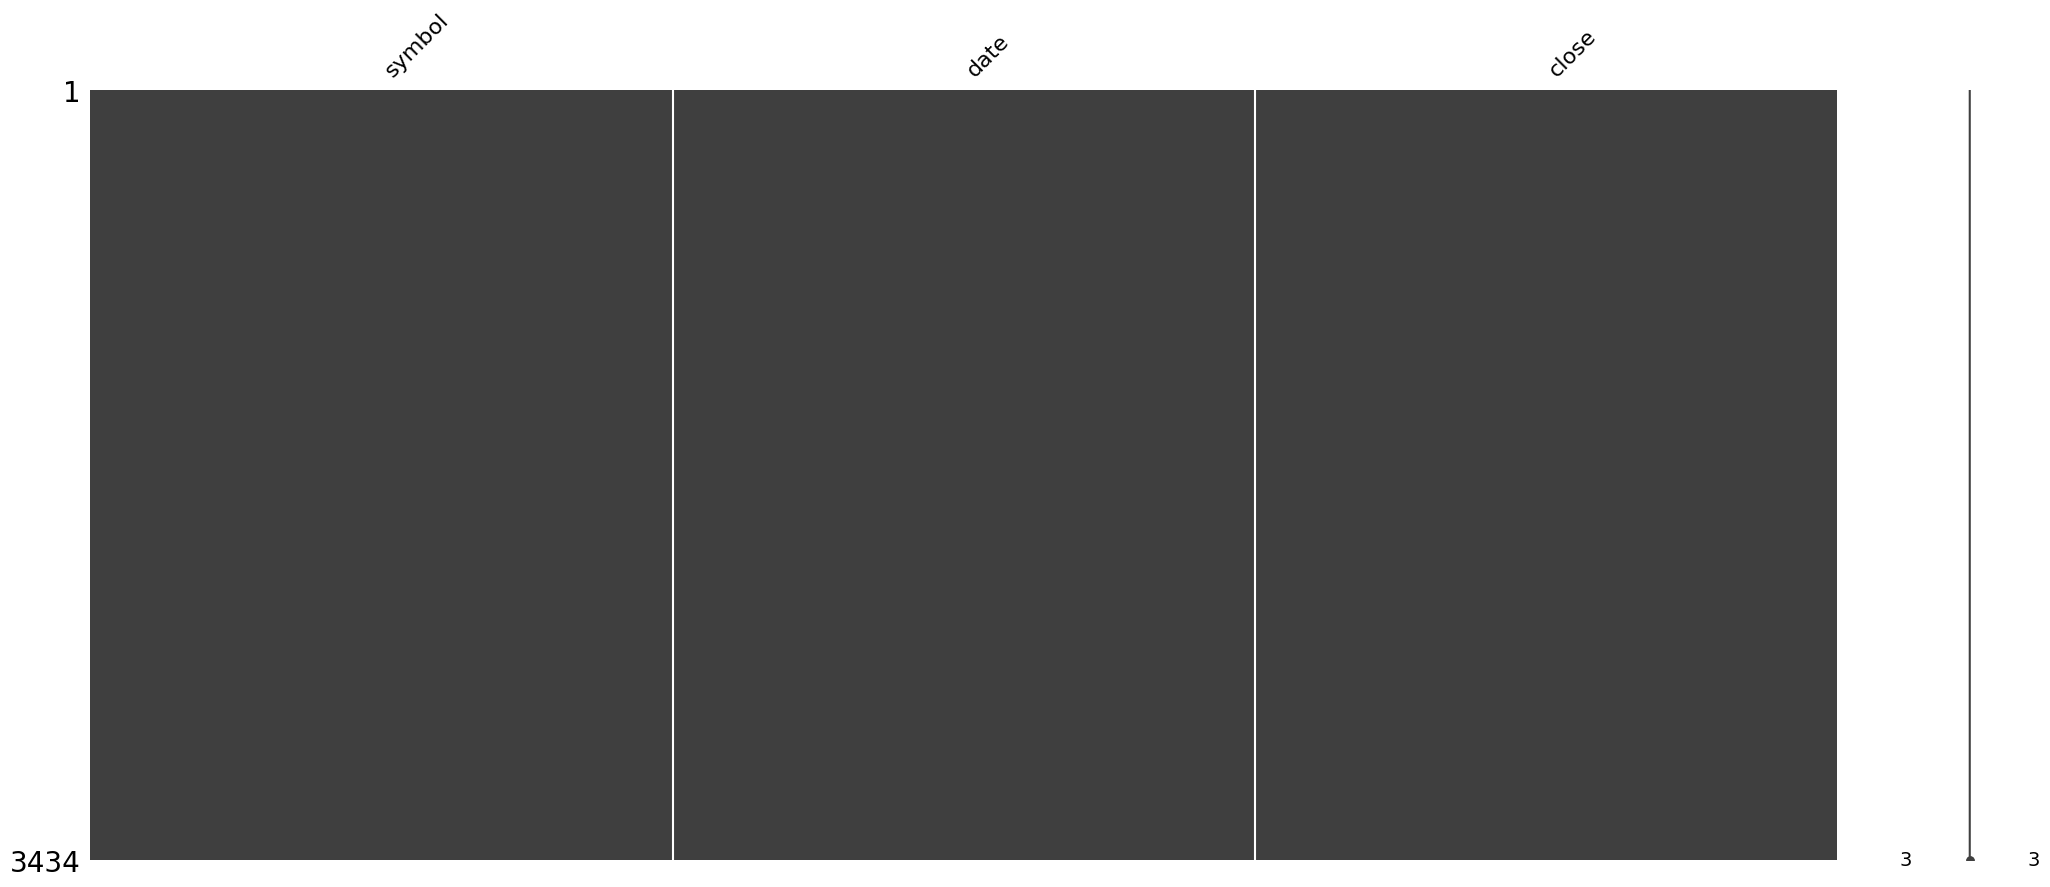

In [59]:

df_final= df_final.dropna(axis=0, how="any")

print(mso.matrix(df_final))

Pivotamos la tabla para graficar más cómodamente y normalizados 

Datos transformados a formato 'ancho' (wide):
symbol        AAPL    GOOG     JPM    MSFT     XOM
date                                              
2023-01-30  143.00   97.95  139.13  242.71  113.56
2023-01-31  144.29   99.87  139.96  247.81  116.01
2023-02-01  145.43  101.43  139.59  252.75  114.74
2023-02-02  150.82  108.80  138.94  264.60  111.15
2023-02-03  154.50  105.22  141.09  258.35  111.92
Generando gráfico de rendimiento normalizado...


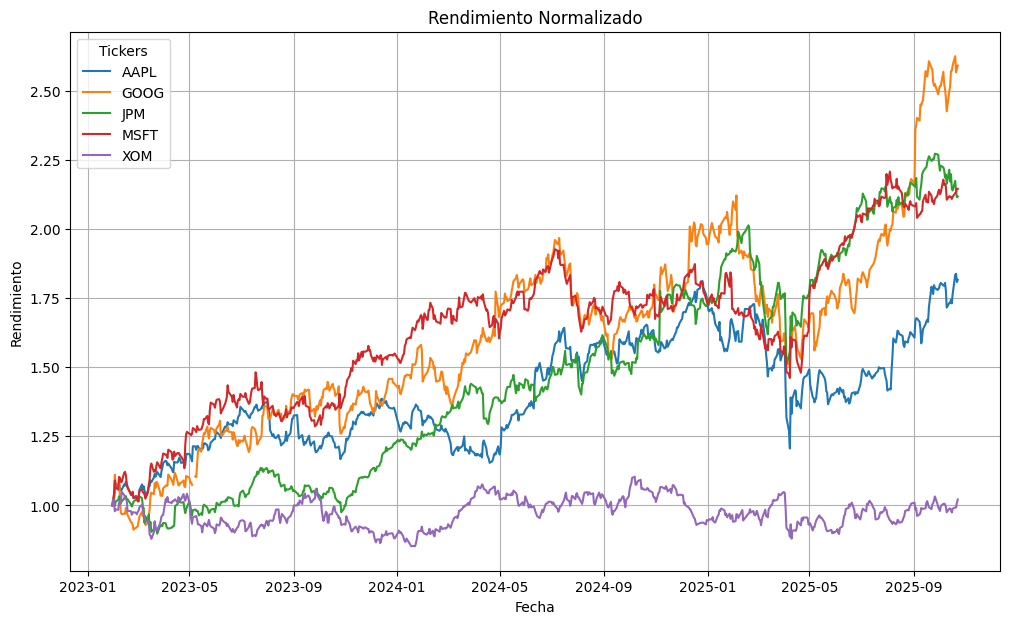

In [60]:
# -- PIVOTAR DATOS PARA GRÁFICOS ---
#

df_wide = df_final.pivot(index='date', columns='symbol', values='close')

print("Datos transformados a formato 'ancho' (wide):")
print(df_wide.head())

# ---  GRÁFICAR DATOS NORMALIZADOS ---

# Importamos la librería de gráficos


# 1. Normalizamos: Dividimos el DataFrame "ancho" por su primera fila (iloc[0])

df_normalizado = (df_wide / df_wide.iloc[0]) 

# 2. Graficamos el DataFrame normalizado
print("Generando gráfico de rendimiento normalizado...")

df_normalizado.plot(figsize=(12, 7))
plt.title('Rendimiento Normalizado')
plt.ylabel('Rendimiento')
plt.xlabel('Fecha')
plt.grid(True)
plt.legend(title='Tickers')
plt.show()

Calculamos la media y mediana de los rendimientos logarítmicos

In [64]:



portfolio_return = log_returns.mean(axis=1)



# -CÁLCULO DE ESTADÍSTICAS ---

# media
mean_returns = log_returns.mean()

# mediana
median_returns = log_returns.median()

print("--- Retornos diarios de la Cartera ---")
print(portfolio_return.head())

print("\n--- Estadísticas de la Cartera ---")
print(f"Media diaria (mu):   {portfolio_return.mean():.6f}")
print(f"Std diaria (sigma): {portfolio_return.std():.6f}")

print("--- Media de Retornos Logarítmicos Diarios ---")
print(mean_returns)

print("\n--- Mediana de Retornos Logarítmicos Diarios ---")
print(median_returns)



--- Retornos diarios de la Cartera ---
date
2023-01-31    0.015296
2023-02-01    0.005891
2023-02-02    0.023180
2023-02-03   -0.002199
2023-02-06   -0.007366
dtype: float64

--- Estadísticas de la Cartera ---
Media diaria (mu):   0.000862
Std diaria (sigma): 0.010427
--- Media de Retornos Logarítmicos Diarios ---
symbol
AAPL    0.000805
GOOG    0.001350
JPM     0.001065
MSFT    0.001100
XOM    -0.000011
dtype: float64

--- Mediana de Retornos Logarítmicos Diarios ---
symbol
AAPL    0.001275
GOOG    0.002469
JPM     0.001690
MSFT    0.001226
XOM     0.000183
dtype: float64


Calculamos retornos logaritmicos y matriz de correlación

DataFrame de Retornos Logarítmicos Diarios:
symbol          AAPL      GOOG       JPM      MSFT       XOM
date                                                        
2023-01-31  0.008981  0.019412  0.005948  0.020795  0.021345
2023-02-01  0.007870  0.015500 -0.002647  0.019739 -0.011008
2023-02-02  0.036392  0.070142 -0.004667  0.045818 -0.031788
2023-02-03  0.024107 -0.033458  0.015356 -0.023904  0.006904
2023-02-06 -0.018091 -0.016772  0.005866 -0.006135 -0.001699


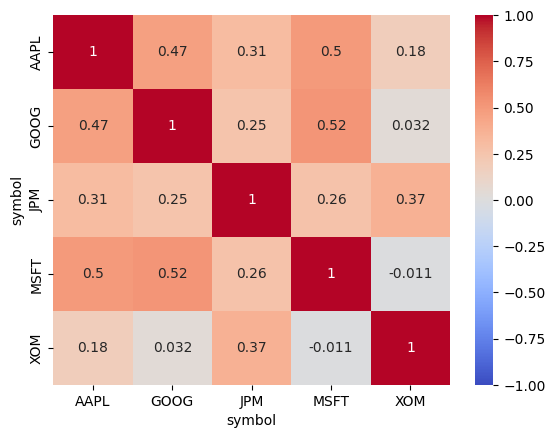

In [62]:

log_returns = np.log(df_wide).diff().dropna()

print("DataFrame de Retornos Logarítmicos Diarios:")
print(log_returns.head())

sns.heatmap(log_returns.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()



Estudio de la media y la mediana comparada con una distribución normal.

Generando análisis de distribución para cada activo...



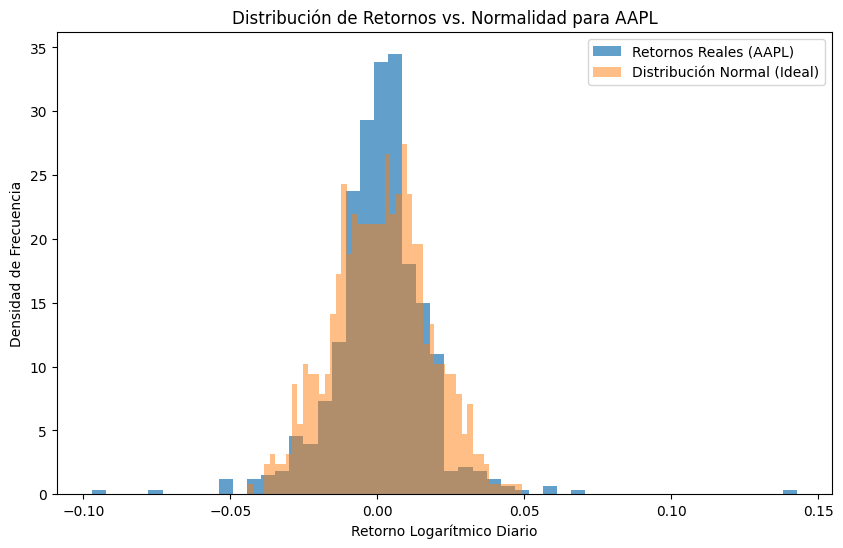

--- Estadísticos para AAPL ---
Media            = 0.000805
Desv. Estándar   = 0.016375
Skewness (Asimetría) = 0.5033
Kurtosis (Curtosis)  = 11.2918
--------------------------------



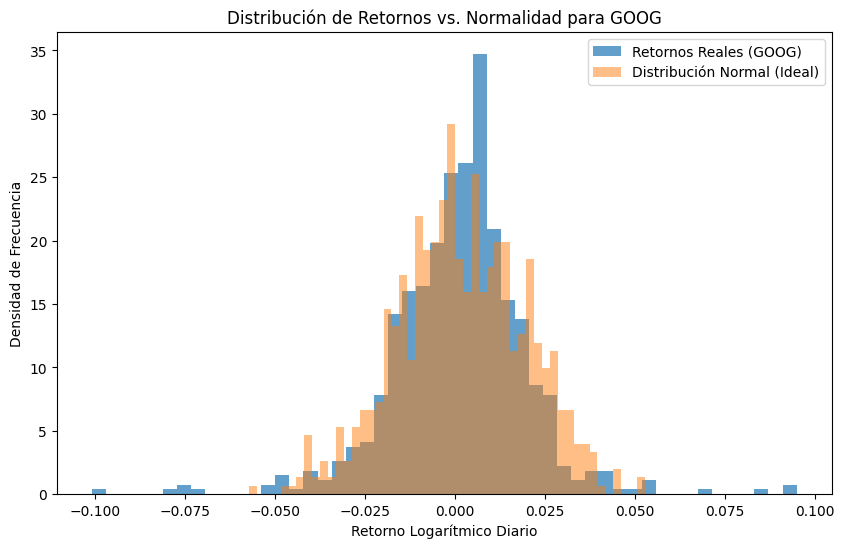

--- Estadísticos para GOOG ---
Media            = 0.001350
Desv. Estándar   = 0.018823
Skewness (Asimetría) = -0.1539
Kurtosis (Curtosis)  = 4.6983
--------------------------------



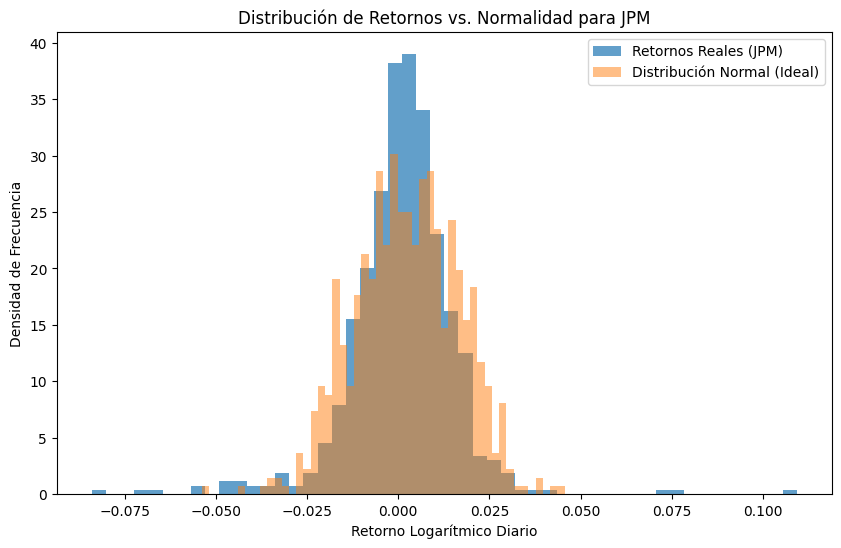

--- Estadísticos para JPM ---
Media            = 0.001065
Desv. Estándar   = 0.014643
Skewness (Asimetría) = -0.1046
Kurtosis (Curtosis)  = 9.5361
-------------------------------



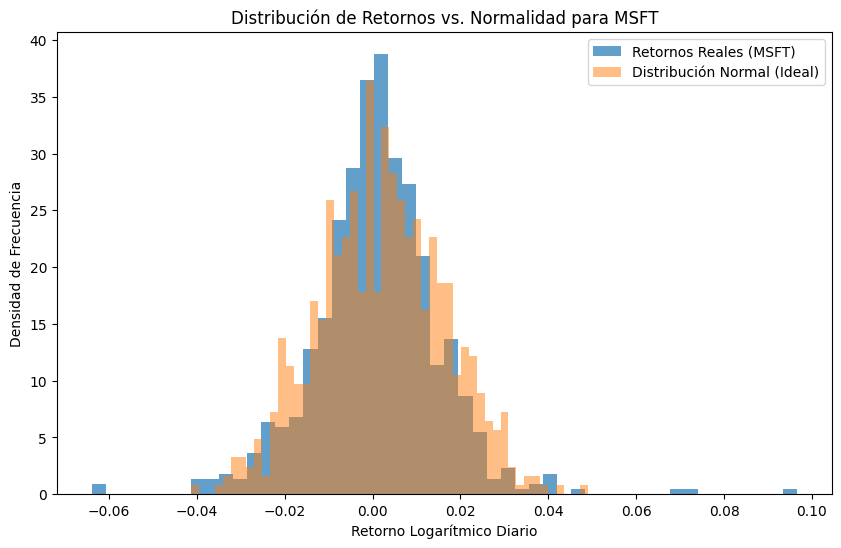

--- Estadísticos para MSFT ---
Media            = 0.001100
Desv. Estándar   = 0.014475
Skewness (Asimetría) = 0.4211
Kurtosis (Curtosis)  = 5.0846
--------------------------------



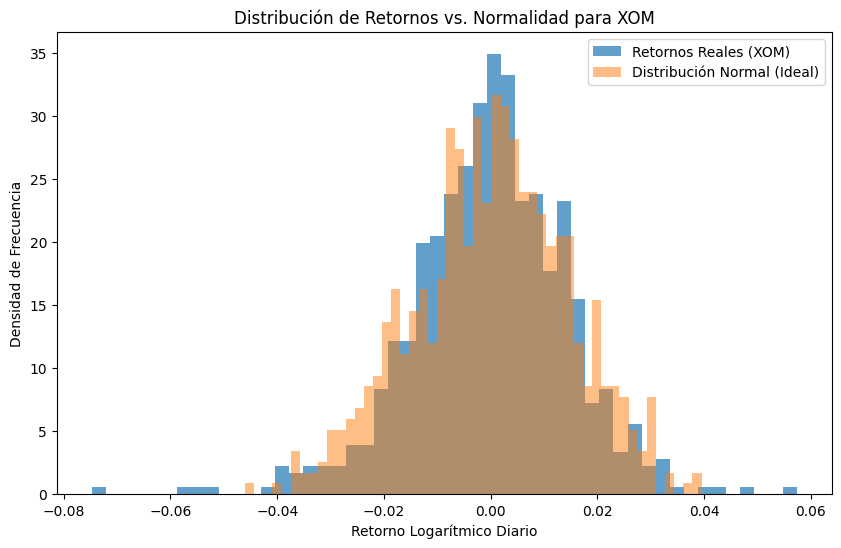

--- Estadísticos para XOM ---
Media            = -0.000011
Desv. Estándar   = 0.014472
Skewness (Asimetría) = -0.3623
Kurtosis (Curtosis)  = 1.9473
-------------------------------



In [63]:
# ---  ANÁLISIS DE DISTRIBUCIÓN DE RETORNOS ---
#
# Comparamos la distribución real de cada activo contra una
# distribución normal "ideal" (generada por computadora)
# que tiene exactamente la misma media y desviación estándar.

# Necesitamos la función para generar números aleatorios
from numpy.random import default_rng
rng = default_rng()

# El DataFrame 'log_returns' ya lo calculamos en la Celda 12
print("Generando análisis de distribución para cada activo...\n")

# Iteramos sobre cada columna (activo) en nuestro DataFrame de retornos
for activo in log_returns.columns:
    
    # 1. Seleccionamos los retornos del activo y quitamos los NaN (por si acaso)
    rets = log_returns[activo].dropna()
    
    # 2. Creamos la distribución "ideal"
    #    Generamos números aleatorios con la misma media (loc) y desv. (scale)
    data_normal = rng.normal(
        size=len(rets),      # Misma cantidad de datos
        loc=rets.mean(),     # Misma media
        scale=rets.std()     # Misma desviación estándar
    )
    
    # 3. Creamos un DataFrame temporal para el gráfico
    df_compare = pd.DataFrame({
        f"Real_{activo}": rets.values, 
        "Normal_Ideal": data_normal
    })
    
    # 4. Graficamos el histograma
    plt.figure(figsize=(10, 6))
    
    # 'density=True' normaliza el histograma para que el área bajo la curva sea 1
    # Esto permite una comparación justa de las formas
    plt.hist(df_compare[f"Real_{activo}"], bins=50, alpha=0.7, label=f"Retornos Reales ({activo})", density=True)
    plt.hist(df_compare["Normal_Ideal"], bins=50, alpha=0.5, label="Distribución Normal (Ideal)", density=True)
    
    plt.title(f"Distribución de Retornos vs. Normalidad para {activo}")
    plt.xlabel("Retorno Logarítmico Diario")
    plt.ylabel("Densidad de Frecuencia")
    plt.legend()
    plt.show()
    
    # 5. Imprimimos los estadísticos clave
    print(f"--- Estadísticos para {activo} ---")
    print(f"Media            = {rets.mean():.6f}")
    print(f"Desv. Estándar   = {rets.std():.6f}")
    print(f"Skewness (Asimetría) = {rets.skew():.4f}")
    print(f"Kurtosis (Curtosis)  = {rets.kurtosis():.4f}")
    print("-"*(28 + len(activo)) + "\n")

Ahora vamos con las simulaciones Monte-Carlo


--- Iniciando Simulación Monte Carlo ---
Parámetros usados para la simulación del portfolio:
  - Valor inicial (S0): 100
  - Días a simular (n_days): 30
  - Número de simulaciones (n_sims): 3000
  - Media diaria retorno log (mu_daily): 0.000862
  - Desv. Est. diaria retorno log (sigma_daily): 0.010427
  - Paso de tiempo (dt): 0.003968

Generando gráfico de las simulaciones...
Gráfico 'monte_carlo_simulation.png' guardado.


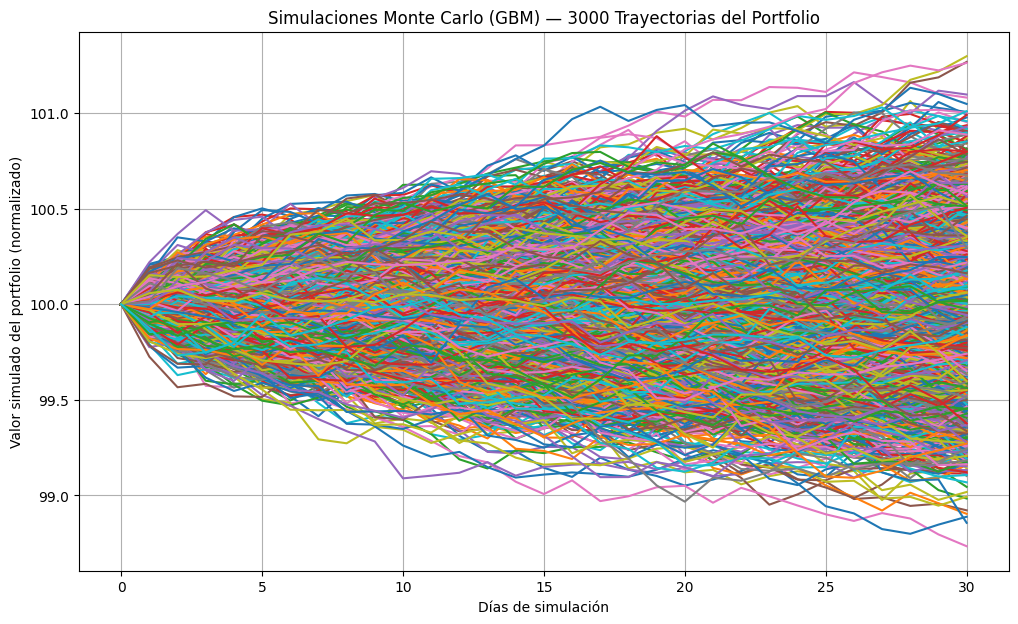

In [69]:

# --- SIMULACIÓN MONTE CARLO ---
print("\n--- Iniciando Simulación Monte Carlo ---")

# Parámetros de la simulación
n_sims = 3000      # Número de simulaciones
n_days = 30       # Días a simular hacia adelante
S0 = 100          # Valor inicial del portfolio (normalizado a 100 para comparar)
dt = 1 / 252      # Paso de tiempo (asumiendo 252 días de trading al año)

try:
    # 1. Asegurarse de tener los retornos logarítmicos de TODOS los activos
    #    (df_wide viene de la celda 17)
    log_returns_mc = np.log(df_wide).diff().dropna()

    # 2. Calcular los retornos diarios de un portfolio EQUITATIVO
    #    (misma inversión en cada activo)
    portfolio_return_mc = log_returns_mc.mean(axis=1)

    # 3. Calcular la media y desviación estándar de los retornos logarítmicos del portfolio
    mu_daily = portfolio_return_mc.mean()
    sigma_daily = portfolio_return_mc.std()

    print(f"Parámetros usados para la simulación del portfolio:")
    print(f"  - Valor inicial (S0): {S0}")
    print(f"  - Días a simular (n_days): {n_days}")
    print(f"  - Número de simulaciones (n_sims): {n_sims}")
    print(f"  - Media diaria retorno log (mu_daily): {mu_daily:.6f}")
    print(f"  - Desv. Est. diaria retorno log (sigma_daily): {sigma_daily:.6f}")
    print(f"  - Paso de tiempo (dt): {dt:.6f}")

    # Inicializar generador de números aleatorios
    rng = default_rng()

    # 4. Generar las trayectorias (Usando Movimiento Browniano Geométrico - GBM)
    paths = np.zeros((n_days + 1, n_sims))
    paths[0, :] = S0 # Establecer el valor inicial para todas las simulaciones

    for t in range(1, n_days + 1):
        # Generar números aleatorios normales estándar para este paso de tiempo
        Z = rng.standard_normal(n_sims)
        # Calcular el precio para este día en todas las simulaciones
        paths[t, :] = paths[t - 1, :] * np.exp(
            (mu_daily - 0.5 * sigma_daily**2) * dt +  # Componente de deriva
            sigma_daily * np.sqrt(dt) * Z             # Componente aleatorio (shock)
        )

    # 5. Graficar las trayectorias simuladas usando Matplotlib
    print("\nGenerando gráfico de las simulaciones...")
    plt.figure(figsize=(12, 7)) # Crear una figura nueva para el gráfico
    plt.plot(paths)
    plt.title(f'Simulaciones Monte Carlo (GBM) — {n_sims} Trayectorias del Portfolio')
    plt.xlabel('Días de simulación')
    plt.ylabel('Valor simulado del portfolio (normalizado)')
    plt.grid(True)
    # No añadimos leyenda para no saturar el gráfico con 100 entradas
    plt.savefig('monte_carlo_simulation.png') # Guardar el gráfico como imagen
    print("Gráfico 'monte_carlo_simulation.png' guardado.")

except NameError as e:
     print(f"Error: La variable 'df_wide' no está definida. Asegúrate de ejecutar la celda 17 antes. ({e})")
except Exception as e:
    print(f"Ocurrió un error inesperado durante la simulación: {e}")

Con estas simulaciones calculamos el Value at risk.(Utiliza los datos de las simulaciones monte Carlo de la celda anterior)


--- Calculando Value at Risk (VaR) ---
Resultados basados en 3000 simulaciones de 30 días:
Nivel de Confianza: 95%
Nivel de Significancia (alpha): 5%
Percentil 5 de retorno simulado a 30 días: -0.0057
Value at Risk (VaR) al 95% de confianza para 30 días: 0.0057 (o 0.57%)
Interpretación: Basado en 3000 simulaciones, hay una probabilidad del 5% de que la pérdida del portfolio exceda el 0.57% en los próximos 30 días.

Generando histograma de retornos simulados a 30 días y VaR...
Gráfico 'monte_carlo_paths_var_histogram.png' guardado.


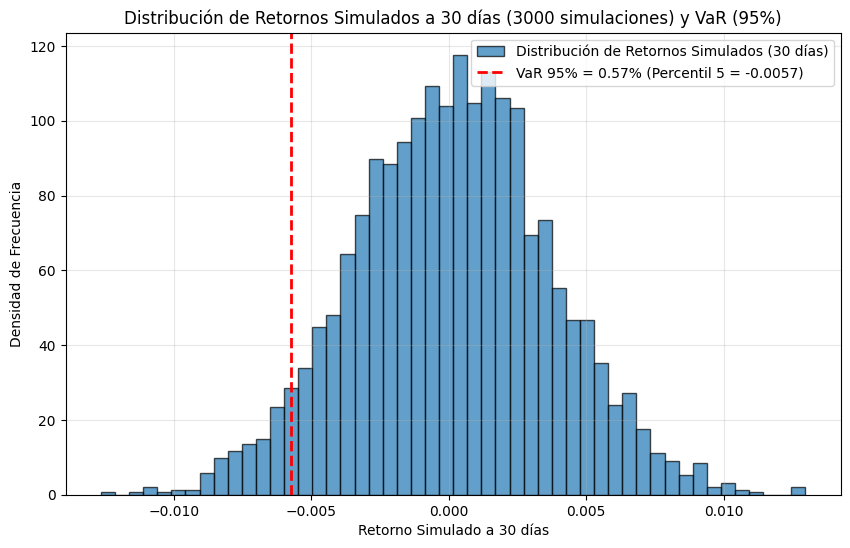

In [70]:

# --- Value at Risk (VaR) Calculation using previous Simulation Paths ---
print("\n--- Calculando Value at Risk (VaR) ---")

try:
    # 1. Verificar si las variables necesarias de la simulación anterior existen
    if 'paths' not in locals() or 'S0' not in locals() or 'n_days' not in locals() or 'n_sims' not in locals():
        raise NameError("Variables de simulación (paths, S0, n_days, n_sims) no encontradas. Ejecuta la celda Monte Carlo de trayectorias primero.")

    # 2. Obtener los valores simulados finales (del último día simulado)
    final_values = paths[n_days, :] # Última fila (día n_days) para todas las simulaciones (n_sims)

    # 3. Calcular los retornos simulados (retornos simples) sobre el período simulado (n_days)
    #    (Valor Final - Valor Inicial) / Valor Inicial
    simulated_returns = (final_values - S0) / S0

    # 4. Definir nivel de confianza y calcular VaR
    confidence_level = 0.95
    alpha = 1 - confidence_level # Nivel de significancia (0.05)

    # VaR es el percentil alpha de las *pérdidas* (retornos negativos),
    # o el negativo del percentil alpha de los *retornos*.
    var_percentile = np.percentile(simulated_returns, alpha * 100) # 5º percentil para confianza del 95%

    # El VaR se expresa como una pérdida potencial positiva
    var_value = -var_percentile

    print(f"Resultados basados en {n_sims} simulaciones de {n_days} días:")
    print(f"Nivel de Confianza: {confidence_level:.0%}")
    print(f"Nivel de Significancia (alpha): {alpha:.0%}")
    print(f"Percentil {alpha*100:.0f} de retorno simulado a {n_days} días: {var_percentile:.4f}")
    print(f"Value at Risk (VaR) al {confidence_level:.0%} de confianza para {n_days} días: {var_value:.4f} (o {var_value:.2%})")
    print(f"Interpretación: Basado en {n_sims} simulaciones, hay una probabilidad del {alpha:.0%} de que la pérdida del portfolio exceda el {var_value:.2%} en los próximos {n_days} días.")

    # 5. Graficar histograma de retornos y marcar el VaR
    print(f"\nGenerando histograma de retornos simulados a {n_days} días y VaR...")
    plt.figure(figsize=(10, 6)) # Crear figura nueva
    plt.hist(simulated_returns, bins=50, alpha=0.7, density=True, edgecolor='black', label=f'Distribución de Retornos Simulados ({n_days} días)')
    # Añadir línea vertical para el VaR (en el valor de pérdida, que es -VaR95)
    plt.axvline(var_percentile, color='r', linestyle='dashed', linewidth=2,
                label=f'VaR {confidence_level:.0%} = {var_value:.2%} (Percentil {alpha*100:.0f} = {var_percentile:.4f})')
    plt.title(f'Distribución de Retornos Simulados a {n_days} días ({n_sims} simulaciones) y VaR ({confidence_level:.0%})')
    plt.xlabel(f'Retorno Simulado a {n_days} días')
    plt.ylabel('Densidad de Frecuencia')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig('monte_carlo_paths_var_histogram.png') # Guardar gráfico
    print("Gráfico 'monte_carlo_paths_var_histogram.png' guardado.")


except NameError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Ocurrió un error inesperado durante el cálculo del VaR: {e}")